In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle

import math
from shapely import Polygon, Point, MultiPoint, MultiPolygon, GeometryCollection
from shapely.ops import voronoi_diagram
from shapely.strtree import STRtree
import pathlib
from numpy.random import randint
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler

In [ ]:
pedpy_blue = (89 / 255, 178 / 255, 216 / 255)
pedpy_orange = (220 / 255, 160 / 255, 73 / 255)
pedpy_green = (108 / 255, 190 / 255, 167 / 255)
pedpy_petrol = (98 / 255, 190 / 255, 190 / 255)
pedpy_grey = (114 / 255, 125 / 255, 139 / 255)
pedpy_red = (233 / 255, 117 / 255, 134 / 255)

In [ ]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
def plot_ped(ax, origin, angle, alpha):
    foot1_vector = (origin[0] + 0.1, origin[1] - 0.15)
    rotate_foot1_vector = (
        math.cos(angle * foot1_vector[0]) - math.sin(angle * foot1_vector[1]),
        math.sin(angle * foot1_vector[0]) + math.cos(angle * foot1_vector[1]),
    )
    foot_1 = Ellipse(
        rotate_foot1_vector, 0.2, 0.1, color="black", fill=False, angle=angle
    )
    foot_2 = Ellipse(
        (origin[0] - 0.1, origin[1] + 0.15),
        0.2,
        0.1,
        color="black",
        fill=False,
        angle=angle,
    )

    body = Ellipse(origin, 0.3, 0.5, color="gray", angle=angle, alpha=alpha)
    head = Ellipse(origin, 0.275, 0.2, color="black", angle=angle, alpha=alpha)

    # print(rotate_foot1_vector)
    # ax.add_patch(foot_1)
    # ax.add_patch(foot_2)
    ax.add_patch(body)
    ax.add_patch(head)
    ax.scatter(*origin, color="white")

# Setup

In [ ]:
output_path = pathlib.Path("images")

In [ ]:
peds = [
    ([0.1, 1.3], 3),
    ([2.6, 2.8], 10),
    ([2.1, 0.5], 4),
    ([1.3, 2.1], -5),
    ([0.4, 3.4], -4),
    ([-0.6, 0.4], 1),
    ([-1, 2.9], 3),
    ([-1.5, 1.5], -7),
    ([-2.1, 3], 8),
    ([-2.5, 0.7], -2),
]

# Classic denisty

In [ ]:
measurement_area = Polygon([(-2, 0), (-2, 4), (2, 4), (2, 0)])
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect("equal")

# ax.fill(*measurement_area.exterior.xy, color="r", alpha=0.05)

ax.plot(*measurement_area.exterior.xy, color=pedpy_red, lw=5)
# ax.fill(
#     *measurement_area.exterior.xy,
#     color=pedpy_blue,
#     alpha=0.1,
# )

for ped in peds:
    alpha = 1 if measurement_area.contains(Point(ped[0])) else 0.5
    plot_ped(ax, ped[0], ped[1], alpha)


ax.set_xlim([-3.1, 3.1])
ax.set_ylim([-0.1, 4.1])
plt.axis("off")
# plt.savefig(output_path / "classic_density.svg", bbox_inches="tight")
plt.show()

# Voronoi

In [ ]:
def compute_voronoi(peds):
    points = MultiPoint([Point(ped[0]) for ped in peds])
    regions = voronoi_diagram(points)

    ped_region = {}
    for region in regions.geoms:
        for ped in peds:
            if Point(ped[0]).within(region):
                ped_region[region] = ped[0]
                continue
    return ped_region

### Without cut-off

In [ ]:
measurement_area = Polygon([(-2, 0), (-2, 4), (2, 4), (2, 0)])
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect("equal")

bounds = Polygon([(-3, 0), (-3, 4), (3, 4), (3, 0)])

for region, ped in compute_voronoi(peds).items():
    intersected_region = region.intersection(bounds)
    ax.plot(*intersected_region.exterior.xy, color="w", lw=3)
    ax.fill(*intersected_region.exterior.xy, color=pedpy_blue, alpha=0.3)
    # ax.fill(
    #     *region.intersection(measurement_area).exterior.xy,
    #     color=pedpy_blue,
    #     alpha=0.4,
    # )

for ped in peds:
    # alpha = 1 if measurement_area.contains(Point(ped[0])) else 0.2
    alpha = 1
    plot_ped(ax, ped[0], ped[1], alpha)

# ax.plot(*measurement_area.exterior.xy, color="r", lw=5)

ax.plot(*bounds.exterior.xy, color="lightgray", lw=10)
ax.set_xlim([-3.1, 3.1])
ax.set_ylim([-0.1, 4.1])
plt.axis("off")
plt.savefig(output_path / "voronoi_wo_cutoff.svg", bbox_inches="tight")
plt.show()

### With cut-off

In [ ]:
measurement_area = Polygon([(-2, 0), (-2, 4), (2, 4), (2, 0)])
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect("equal")

bounds = Polygon([(-3, 0), (-3, 4), (3, 4), (3, 0)])

for region, ped in compute_voronoi(peds).items():
    cut_off_region = region.intersection(Point(ped).buffer(0.8, quad_segs=5))
    intersected_region = cut_off_region.intersection(bounds)

    ax.plot(*intersected_region.exterior.xy, color="w", lw=3)
    ax.fill(*intersected_region.exterior.xy, color=pedpy_blue, alpha=0.3)
    # ax.fill(
    #     *region.intersection(measurement_area).exterior.xy,
    #     color=pedpy_blue,
    #     alpha=0.4,
    # )

for ped in peds:
    # alpha = 1 if measurement_area.contains(Point(ped[0])) else 0.2
    alpha = 1
    plot_ped(ax, ped[0], ped[1], alpha)

# ax.plot(*measurement_area.exterior.xy, color="r", lw=5)

ax.plot(*bounds.exterior.xy, color="lightgray", lw=10)
ax.set_xlim([-3.1, 3.1])
ax.set_ylim([-0.1, 4.1])
plt.axis("off")
plt.savefig(output_path / "voronoi_w_cutoff.svg", bbox_inches="tight")
plt.show()

### Difference quad segments

In [ ]:
import shapely

n_peds = 8
fig, axes = plt.subplots(nrows=2, ncols=int(n_peds / 2), figsize=(25, 12.5))

factor = 1
for ax in axes.ravel():
    ax.plot([0, 0], [0, 1.25], color="grey", lw=2, marker="", linestyle="--")
    ax.plot([0, 1.25], [0, 0], color="grey", lw=2, marker="", linestyle="--")

    cut_off_region = Point([0, 0]).buffer(1, quadsegs=factor)

    ax.plot(
        *cut_off_region.exterior.xy,
        color=pedpy_blue,
        lw=3,
        marker="o",
        markerfacecolor=pedpy_blue,
    )
    ax.fill(*cut_off_region.exterior.xy, color=pedpy_blue, alpha=0.1)

    quarter_circle = shapely.LineString(
        cut_off_region.exterior.coords[-factor - 1 :]
    )
    ax.plot(
        *quarter_circle.xy,
        color="r",
        lw=3,
        markersize=6,
        marker="o",
        markerfacecolor="r",
    )

    ax.text(  #
        # 0, -1.25, f"edges = {4*factor}\narea = $r * {cut_off_region.area:0.3f}\,m^2$",
        0,
        -1.2,
        f"quad-segments = {factor}",
        size=25,
        va="center",
        ha="center",
    )

    factor += 1
    plot_ped(ax, [0, 0], 0, 1)
    ax.set_aspect("equal")
    ax.axis("off")

plt.savefig(output_path / "voronoi_cutoff_differences.svg", bbox_inches="tight")
plt.show()

# Speed

## Both sides

In [ ]:
alpha = 0.5
np.random.seed(2)
x = np.linspace(-1, 1, 1000)

y = np.convolve(
    randint(0, 100) * np.sin(randint(0, 100) * x),
    randint(0, 100) * np.cos(randint(0, 100) * x),
    "same",
)
y = (
    MinMaxScaler(feature_range=(-0.07, 0.07))
    .fit_transform(y.reshape(-1, 1))
    .reshape(-1)
)

fig, ax = plt.subplots(figsize=(20, 20))
plot_ped(ax, [0, 0], 25, alpha)

ax.arrow(0, 0, 0.2, 0.1, width=0.01, alpha=1, color=pedpy_orange)


ax.plot(
    x, y, c=pedpy_blue, marker="o", markevery=25, alpha=1, lw=5, markersize=10
)
index_left = int(len(x) / 2 - len(x) / 4)
index_right = int(len(x) / 2 + len(x) / 4)
ax.plot(
    [x[index_right], x[int(len(x) / 2)], x[index_left]],
    [y[index_right], y[int(len(x) / 2)], y[index_left]],
    c=pedpy_red,
    marker="o",
    lw=5,
    markersize=10,
)
ax.annotate(
    "n frames before current frame",
    fontsize=30,
    xy=(
        x[index_left] + 0.5 * (x[int(len(x) / 2)] - x[index_left]),
        y[index_left] + 0.5 * (y[int(len(x) / 2)] - y[index_left]) - 0.07,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=5.6, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        x[index_left] + 0.5 * (x[int(len(x) / 2)] - x[index_left]),
        y[index_left] + 0.5 * (y[int(len(x) / 2)] - y[index_left]) - 0.22,
    ),
)

ax.annotate(
    "n frames after current frame",
    fontsize=30,
    xy=(
        x[index_right] + 0.5 * (x[int(len(x) / 2)] - x[index_right]),
        y[index_right] + 0.5 * (y[int(len(x) / 2)] - y[index_right]) - 0.05,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=5.6, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        x[index_right] + 0.5 * (x[int(len(x) / 2)] - x[index_right]),
        y[index_right] + 0.5 * (y[int(len(x) / 2)] - y[index_right]) - 0.3,
    ),
)

ax.annotate(
    "$X_{past}$",
    xy=(-0.51, 0.03),
    xycoords="data",
    xytext=(-0.6, 0.1),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{current}$",
    xy=(-0.01, 0.01),
    xycoords="data",
    xytext=(-0.3, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{future}$",
    xy=(0.505, -0.0),
    xycoords="data",
    xytext=(0.6, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)

ax.set_xlim([-0.82, 0.82])
ax.set_aspect("equal")
# alpha = 0.5
plt.axis("off")
plt.savefig(output_path / "speed_both.svg", bbox_inches="tight", pad_inches=0)
# plt.show()

## border single sided

### past

In [ ]:
np.random.seed(2)
x = np.linspace(-1, 1, 1000)

# y = randint(0, 100)*np.sin(randint(0,100)*x)+randint(0,100)*np.cos(randint(0,100)*x)
y = np.convolve(
    randint(0, 100) * np.sin(randint(0, 100) * x),
    randint(0, 100) * np.cos(randint(0, 100) * x),
    "same",
)
y = (
    MinMaxScaler(feature_range=(-0.07, 0.07))
    .fit_transform(y.reshape(-1, 1))
    .reshape(-1)
)

fig, ax = plt.subplots(figsize=(20, 20))
plot_ped(ax, [0, 0], 25, alpha)

ax.plot(
    x[:701],
    y[:701],
    c=pedpy_blue,
    marker="o",
    markevery=25,
    alpha=1,
    lw=5,
    markersize=10,
)
index_left = int(len(x) / 2 - len(x) / 4)
index_right = int(len(x) / 2 + len(x) / 4)
ax.plot(
    [x[int(len(x) / 2)], x[index_left]],
    [y[int(len(x) / 2)], y[index_left]],
    c=pedpy_red,
    marker="o",
    lw=5,
    markersize=10,
)
ax.arrow(0, 0, 0.2, 0.1, width=0.01, alpha=1, color=pedpy_orange)
ax.annotate(
    "n frames before current frame",
    fontsize=30,
    xy=(
        x[index_left] + 0.5 * (x[int(len(x) / 2)] - x[index_left]),
        y[index_left] + 0.5 * (y[int(len(x) / 2)] - y[index_left]) - 0.07,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=5.6, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        x[index_left] + 0.5 * (x[int(len(x) / 2)] - x[index_left]),
        y[index_left] + 0.5 * (y[int(len(x) / 2)] - y[index_left]) - 0.22,
    ),
)
ax.annotate(
    "$X_{past}$",
    xy=(-0.51, 0.03),
    xycoords="data",
    xytext=(-0.6, 0.1),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{current}$",
    xy=(-0.01, 0.01),
    xycoords="data",
    xytext=(-0.3, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.set_xlim([-0.82, 0.82])
ax.set_aspect("equal")
alpha = 0.5
plt.axis("off")
plt.savefig(
    output_path / "speed_border_single_sided_past.svg",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

### future

In [ ]:
np.random.seed(2)
x = np.linspace(-1, 1, 1000)

y = np.convolve(
    randint(0, 100) * np.sin(randint(0, 100) * x),
    randint(0, 100) * np.cos(randint(0, 100) * x),
    "same",
)
y = (
    MinMaxScaler(feature_range=(-0.07, 0.07))
    .fit_transform(y.reshape(-1, 1))
    .reshape(-1)
)

fig, ax = plt.subplots(figsize=(20, 20))
plot_ped(ax, [0, 0], 25, alpha)

ax.plot(
    x[300:],
    y[300:],
    c=pedpy_blue,
    marker="o",
    markevery=25,
    alpha=1,
    lw=5,
    markersize=10,
)
index_left = int(len(x) / 2 - len(x) / 4)
index_right = int(len(x) / 2 + len(x) / 4)
ax.plot(
    [x[index_right], x[int(len(x) / 2)]],
    [y[index_right], y[int(len(x) / 2)]],
    c=pedpy_red,
    marker="o",
    lw=5,
    markersize=10,
)
ax.arrow(0, 0, 0.2, 0.1, width=0.01, alpha=1, color=pedpy_orange)

ax.annotate(
    "n frames after current frame",
    fontsize=30,
    xy=(
        x[index_right] + 0.5 * (x[int(len(x) / 2)] - x[index_right]),
        y[index_right] + 0.5 * (y[int(len(x) / 2)] - y[index_right]) - 0.05,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=5.6, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        x[index_right] + 0.5 * (x[int(len(x) / 2)] - x[index_right]),
        y[index_right] + 0.5 * (y[int(len(x) / 2)] - y[index_right]) - 0.3,
    ),
)

ax.annotate(
    "$X_{current}$",
    xy=(-0.01, 0.01),
    xycoords="data",
    xytext=(-0.3, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{future}$",
    xy=(0.505, -0.0),
    xycoords="data",
    xytext=(0.6, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)


ax.set_xlim([-0.82, 0.82])
ax.set_aspect("equal")
alpha = 0.5
plt.axis("off")
plt.savefig(
    output_path / "speed_border_single_sided_future.svg",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

## border adaptive

### past

In [ ]:
np.random.seed(2)
x = np.linspace(-1, 1, 1000)

y = np.convolve(
    randint(0, 100) * np.sin(randint(0, 100) * x),
    randint(0, 100) * np.cos(randint(0, 100) * x),
    "same",
)
y = (
    MinMaxScaler(feature_range=(-0.07, 0.07))
    .fit_transform(y.reshape(-1, 1))
    .reshape(-1)
)

end_idx = 701
marker_distance = 25
x = x[:end_idx]
y = y[:end_idx]
x_marker = x[::marker_distance]
y_marker = y[::marker_distance]

fig, ax = plt.subplots(figsize=(20, 30))
plot_ped(ax, [0, 0], 25, alpha)

ax.plot(
    x,
    y,
    c=pedpy_blue,
    marker="o",
    markevery=marker_distance,
    alpha=1,
    lw=5,
    markersize=10,
)

index_right = len(x_marker) - 1
index_middle = index_right - 8
index_left = index_right - 16

ax.plot(
    [x_marker[index_right], x_marker[index_middle], x_marker[index_left]],
    [y_marker[index_right], y_marker[index_middle], y_marker[index_left]],
    c=pedpy_red,
    marker="o",
    lw=5,
    markersize=10,
)
ax.arrow(0, 0, 0.2, 0.1, width=0.01, alpha=1, color=pedpy_orange)

ax.annotate(
    "n frames before current frame",
    fontsize=30,
    xy=(
        (x_marker[index_middle] + x_marker[index_left]) / 2,
        (y_marker[index_middle] + y_marker[index_left]) / 2 - 0.095,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=4.5, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        (x_marker[index_middle] + x_marker[index_left]) / 2,
        (y_marker[index_middle] + y_marker[index_left]) / 2 - 0.5,
    ),
)

ax.annotate(
    "n available frames \nafter current frame",
    fontsize=30,
    xy=(
        (x_marker[index_right] + x_marker[index_middle]) / 2,
        (y_marker[index_right] + y_marker[index_middle]) / 2 - 0.064,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=4.5, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        (x_marker[index_right] + x_marker[index_middle]) / 2,
        (y_marker[index_right] + y_marker[index_middle]) / 2 - 0.35,
    ),
)

ax.annotate(
    "$X_{past}$",
    xy=(-0.41, 0.05),
    xycoords="data",
    xytext=(-0.5, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{current}$",
    xy=(-0.01, 0.01),
    xycoords="data",
    xytext=(-0.3, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{future}$",
    xy=(0.405, -0.02),
    xycoords="data",
    xytext=(0.6, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)


ax.set_xlim([-0.82, 0.82])
ax.set_aspect("equal")
plt.axis("off")
plt.savefig(
    output_path / "speed_border_adaptive_past.svg",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

### future

In [ ]:
np.random.seed(2)
x = np.linspace(-1, 1, 1000)

y = np.convolve(
    randint(0, 100) * np.sin(randint(0, 100) * x),
    randint(0, 100) * np.cos(randint(0, 100) * x),
    "same",
)
y = (
    MinMaxScaler(feature_range=(-0.07, 0.07))
    .fit_transform(y.reshape(-1, 1))
    .reshape(-1)
)

start_idx = 300
marker_distance = 25
x = x[start_idx:]
y = y[start_idx:]
x_marker = x[::marker_distance]
y_marker = y[::marker_distance]

fig, ax = plt.subplots(figsize=(20, 30))
plot_ped(ax, [0, 0], 25, alpha)

ax.plot(
    x,
    y,
    c=pedpy_blue,
    marker="o",
    markevery=marker_distance,
    alpha=1,
    lw=5,
    markersize=10,
)


index_left = 0
index_right = 16
ax.plot(
    [
        x_marker[index_right],
        x_marker[int((index_right - index_left) / 2)],
        x_marker[index_left],
    ],
    [
        y_marker[index_right],
        y_marker[int((index_right - index_left) / 2)],
        y_marker[index_left],
    ],
    c=pedpy_red,
    marker="o",
    lw=5,
    markersize=10,
)
ax.arrow(0, 0, 0.2, 0.1, width=0.01, alpha=1, color=pedpy_orange)

ax.annotate(
    "n available frames before current frame",
    fontsize=30,
    xy=(
        x_marker[int((8 - index_left) / 2)],
        y_marker[int((8 - index_left) / 2)] - 0.075,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=4.5, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        x_marker[int((8 - index_left) / 2)],
        y_marker[int((8 - index_left) / 2)] - 0.5,
    ),
)

ax.annotate(
    "n frames after current frame",
    fontsize=30,
    xy=(
        x_marker[int((index_right - 8) / 2 + 8)],
        y_marker[int((index_right - 8) / 2 + 8)] - 0.055,
    ),
    arrowprops=dict(arrowstyle="-[, widthB=4.5, lengthB=0.5", lw=2.0),
    ha="center",
    va="bottom",
    xytext=(
        x_marker[int((index_right - 8) / 2 + 8)],
        y_marker[int((index_right - 8) / 2 + 8)] - 0.3,
    ),
)

ax.annotate(
    "$X_{past}$",
    xy=(-0.41, 0.05),
    xycoords="data",
    xytext=(-0.5, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{current}$",
    xy=(-0.01, 0.01),
    xycoords="data",
    xytext=(-0.3, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{future}$",
    xy=(0.405, -0.02),
    xycoords="data",
    xytext=(0.6, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)


ax.set_xlim([-0.82, 0.82])
ax.set_aspect("equal")
plt.axis("off")
plt.savefig(
    output_path / "speed_border_adaptive_future.svg",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

## Movement direction

In [ ]:
alpha = 0.5
np.random.seed(2)
x = np.linspace(-1, 1, 1000)

y = np.convolve(
    randint(0, 100) * np.sin(randint(0, 100) * x),
    randint(0, 100) * np.cos(randint(0, 100) * x),
    "same",
)
y = (
    MinMaxScaler(feature_range=(-0.07, 0.07))
    .fit_transform(y.reshape(-1, 1))
    .reshape(-1)
)

fig, ax = plt.subplots(figsize=(20, 20))
plot_ped(ax, [0, 0], 25, alpha)

ax.plot(
    x, y, c=pedpy_blue, marker="o", markevery=25, alpha=1, lw=5, markersize=10
)
index_left = int(len(x) / 2 - len(x) / 4) - 50
index_right = int(len(x) / 2 + len(x) / 4) + 50

ax.annotate(
    "$X_{past}$",
    xy=(-0.6, -0.05),
    xycoords="data",
    xytext=(-0.6, 0.1),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{current}$",
    xy=(-0.01, 0.01),
    xycoords="data",
    xytext=(-0.3, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_petrol
    ),
)

ax.annotate(
    "$X_{future}$",
    xy=(0.60, 0.08),
    xycoords="data",
    xytext=(0.6, 0.2),
    textcoords="data",
    size=30,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_petrol
    ),
)


ax.arrow(
    x[index_left],
    y[index_left],
    np.abs(x[index_right] - x[index_left] - 0.05),
    y[index_right] - y[index_left] - 0.0,
    width=0.01,
    alpha=1,
    color=pedpy_orange,
)

ax.arrow(
    x[index_left],
    y[index_left] - 0.3,
    x[index_right] - x[index_left] - 0.05,
    0,
    width=0.01,
    alpha=1,
    color=pedpy_red,
)

ax.arrow(
    x[index_left],
    y[index_left] - 0.3,
    1,
    0,
    width=0.01,
    alpha=1,
    color=pedpy_grey,
    linestyle="--",
)

ax.plot(
    [x[index_left], x[index_left]],
    [y[index_left], y[index_left] - 0.3],
    lw=3,
    linestyle="--",
    color="grey",
)
ax.plot(
    [x[index_right], x[index_right]],
    [y[index_right], y[index_left] - 0.3],
    lw=3,
    linestyle="--",
    color="grey",
)

ax.set_xlim([-0.82, 0.82])
ax.set_aspect("equal")
# alpha = 0.5
plt.axis("off")
plt.savefig(
    output_path / "speed_movement_direction.svg",
    bbox_inches="tight",
    pad_inches=0,
)
plt.show()

# Profiles

In [ ]:
from shapely import Polygon
from pedpy import WalkableArea

obstacles = [
    [(-9, -2), (-9, 0), (9, 0), (9, -2), (-9, -2)],
    [(-9, 5), (-9, 7), (9, 7), (9, 5), (-9, 5)],
]
walkable_area = WalkableArea(
    Polygon([(-10, -3), (-10, 8), (10, 8), (10, -3)], obstacles)
)

In [ ]:
from pedpy import plot_measurement_setup, MeasurementArea
from pedpy.methods.profile_calculator import _get_grid_cells

cells = _get_grid_cells(walkable_area=walkable_area, grid_size=0.5)

grid_cells = [MeasurementArea(cell) for cell in cells[0]]
plot_measurement_setup(
    walkable_area=walkable_area,
    hole_color="lightgrey",
    measurement_areas=grid_cells,
    ma_line_color=pedpy_orange,
    ma_line_width=0.5,
    ma_alpha=0,
).set_aspect("equal")
plt.savefig(output_path / "profile_grid.svg", bbox_inches="tight")
plt.axis("off")

plt.show()

# Frame range in area

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

plt.fill([0, 0, 5, 5], [0, 1, 1, 0], c=pedpy_green, alpha=0.1)
plt.plot([0, 5], [0, 0], c=pedpy_green, linestyle="--")
plt.plot([0, 5], [1, 1], c=pedpy_green, linestyle="--")

plt.plot([0, 0], [0, 1], c=pedpy_blue, lw=3, marker="o", markersize=7)
plt.plot([5, 5], [0, 1], c=pedpy_orange, lw=3, marker="o", markersize=7)

ax.annotate(
    "width",
    xy=(
        2.5,
        -0.3,
    ),
    size=15,
    arrowprops=dict(arrowstyle="-[, widthB=10.9, lengthB=0.5", lw=1.0),
    ha="center",
    va="bottom",
    xytext=(
        2.5,
        -1,
    ),
)

ax.annotate(
    "measurement\nline",
    xy=(-0.1, 0.5),
    xycoords="data",
    xytext=(-0.5, 1.4),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_blue
    ),
)

ax.annotate(
    "virtual\nmeasurement\nline",
    xy=(5.1, 0.5),
    xycoords="data",
    xytext=(5.5, 1.4),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.2", color=pedpy_blue
    ),
)

ax.set_aspect("equal")
plt.ylim([-1, 1.2])
plt.axis("off")

plt.savefig(output_path / "passing_area_from_lines.svg", bbox_inches="tight")

plt.show()

# Flow


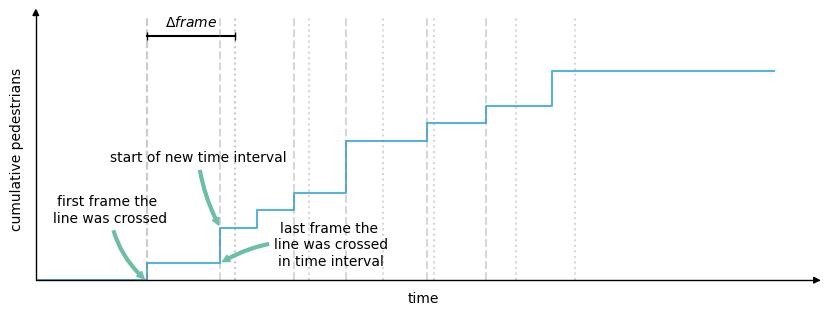

In [222]:
from mpl_toolkits.axisartist.axislines import AxesZero

x = [0, 15, 15, 25, 25, 30, 30, 35, 35, 42, 42, 53, 53, 61, 61, 70, 70, 100]
y = [0, 0, 1, 1, 3, 3, 4, 4, 5, 5, 8, 8, 9, 9, 10, 10, 12, 12]


fig = plt.figure(figsize=(10, 3.4))
ax = fig.add_subplot(axes_class=AxesZero)

ax.plot(x, y, color=pedpy_blue)


for direction in ["xzero", "yzero"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_axisline_style("-|>")

    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

ax.annotate(
    "first frame the \nline was crossed",
    xy=(x[1] - 0.025, y[1] - 0.02),
    xycoords="data",
    xytext=(10, 4),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_green
    ),
)

ax.annotate(
    "last frame the \nline was crossed\nin time interval",
    xy=(x[3] - 0.025, y[3] - 0.02),
    xycoords="data",
    xytext=(40, 2),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.2", color=pedpy_green
    ),
)

ax.annotate(
    "start of new time interval",
    xy=(x[3] - 0.025, y[4] + 0.02),
    xycoords="data",
    xytext=(22, 7),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.1", color=pedpy_green
    ),
)

steps = 12
# for i in range(x[1], 100, steps):
ax.plot([x[1], x[1]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.4)
ax.plot(
    [x[1] + 1 * steps, x[1] + 1 * steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.4,
)
ax.plot([x[1], x[1] + 1 * steps], [14, 14], c="k", marker="|")
ax.text(
    x[1] + 0.5 * steps,
    14.5,
    r"$\Delta frame$",
    horizontalalignment="center",
)

ax.plot([x[3], x[3]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.3)
ax.plot(
    [x[3] + steps, x[3] + steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.3,
)

ax.plot([x[7], x[7]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.3)
ax.plot(
    [x[7] + steps, x[7] + steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.3,
)

ax.plot([x[9], x[9]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.3)
ax.plot(
    [x[9] + steps, x[9] + steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.3,
)

ax.plot([x[11], x[11]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.3)
ax.plot(
    [x[11] + steps, x[11] + steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.3,
)

ax.plot([x[13], x[13]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.3)
ax.plot(
    [x[13] + steps, x[13] + steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.3,
)


ax.set_xlabel("time")
ax.set_ylabel("cumulative pedestrians")

ax.set_xlim([0, None])
ax.set_ylim([0, 15])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(output_path / "flow.svg", bbox_inches="tight")

plt.show()

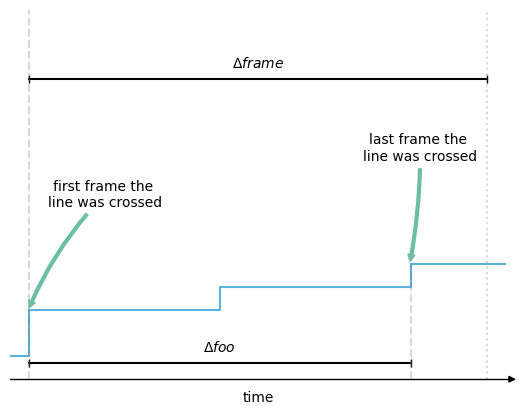

In [225]:
from mpl_toolkits.axisartist.axislines import AxesZero

x = [0, 15, 15, 25, 25, 30, 30, 35, 35, 42, 42, 53, 53, 61, 61, 70, 70, 100]
y = [0, 0, 1, 1, 3, 3, 4, 4, 5, 5, 8, 8, 9, 9, 10, 10, 12, 12]


fig = plt.figure()
ax = fig.add_subplot(axes_class=AxesZero)

ax.plot(x, y, color=pedpy_blue)


for direction in ["xzero", "yzero"]:
    # adds arrows at the ends of each axis
    ax.axis[direction].set_axisline_style("-|>")

    # adds X and Y-axis from the origin
    ax.axis[direction].set_visible(True)

for direction in ["left", "right", "bottom", "top"]:
    # hides borders
    ax.axis[direction].set_visible(False)

ax.axis["yzero"].set_visible(False)

ax.annotate(
    "first frame the \nline was crossed",
    xy=(x[4] - 0.025, y[4] - 0.02),
    xycoords="data",
    xytext=(x[4] + 2, y[4] + 5),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=0.1", color=pedpy_green
    ),
)
ax.annotate(
    "last frame the \nline was crossed",
    xy=(x[8] - 0.025, y[8] - 0.02),
    xycoords="data",
    xytext=(x[8] + 0.25, y[8] + 5),
    textcoords="data",
    size=10,
    va="center",
    ha="center",
    arrowprops=dict(
        arrowstyle="simple", connectionstyle="arc3,rad=-0.05", color=pedpy_green
    ),
)

ax.plot([x[3], x[3] + steps], [y[3] + 12, y[3] + 12], c="k", marker="|")
ax.text(
    x[3] + 0.5 * steps,
    y[3] + 12.5,
    r"$\Delta frame$",
    horizontalalignment="center",
)

ax.plot([x[3], x[8]], [y[3] - 0.3, y[3] - 0.3], c="k", marker="|")
ax.text(
    x[3] + 0.5 * (x[8] - x[3]),
    y[3] + 0.2,
    r"$\Delta foo$",
    horizontalalignment="center",
)


ax.plot([x[3], x[3]], [0, 25], linestyle="--", c=pedpy_grey, alpha=0.3)
ax.plot(
    [x[3] + steps, x[3] + steps],
    [0, 25],
    linestyle=":",
    c=pedpy_grey,
    alpha=0.3,
)
ax.plot([x[8], x[8]], [0, y[8]], linestyle="--", c=pedpy_grey, alpha=0.3)

ax.set_xlabel("time")
ax.set_ylabel("cumulative pedestrians")

ax.set_xlim([x[3] - 0.5, x[3] + steps + 0.5])
ax.set_ylim([0, 16])
ax.set_xticks([])
ax.set_yticks([])

plt.savefig(output_path / "flow_zoom.svg", bbox_inches="tight")

plt.show()